# Track Tree - Epic Tree Timecourse Visualization

by Jonas Hartmann, Gilmour group, EMBL Heidelberg

----

### About


#### Purpose

This pipeline reads timecourse data of a tracked object that divides into multiple objects over time (for example a cell as observed with a fluorescence microscope and tracked by image analysis) and plots the track data as a tree, visualizing measurements as an outline and/or through coloring.


#### Requirements / Assumptions


- There should be only **one root** (one starting object)
    - (Note to self: this could perhaps be overcome by introducing a 'hidden root')


- Input data is supplied in **tab-separated txt files**:
    - **tree_struct.txt** contains the structure of the tree
        - It features the columns *trackID, stemID, branchID1, branchID2*
        - Each row represents an object that exists at some point in the timecourse
            - It could be the initial object (root) or an object generated by a division
        - The *trackID* is a unique string ID of the row's object
        - The *stemID* is the ID of the 'ancestor' of the row's object
            - If the row is the initial object (root), the *stemID* must be `_root_`
        - The *branchID1* and *branchID2* columns are the IDs of the two 'descendents' of the row's object
            - I fht row is a final object (a leaf on the tree), the branchIDs must both be `_leaf_`
    - **track_measure_N.txt**, where N is an integer
        - These files contain measured data about the objects at each timecourse
        - The plots can display up to two different measures
        - Track measures have an `index` column, which enumerates the entire timecourse
        - All other columns are the different object `IDs` as defined in `tree_struct.txt`
        - The columns contain the measures value for those timepoints when the corresponding object exists
        - All other timepoints should be `nan`
        - (Yes, this is not a nice and sparse representation of the data... but I can't be bothered...)
    - *If this description is unclear, you can probably figure it out just by looking at the example data! :P*


#### Notes

- This pipeline was put together to analyze a specific dataset and was quickly generalized to release it on GitHub. It is not throughly tested and it is not a "ready to use tool". Use at your own risk!


- To visualize your own data with this pipeline you'll have to modify the `Parameters` code cell appropriately. This should be straightforward but there's a good chance that things won't "just work". In that case you'll have to debug on your own...


- The scaling of the plots may not work perfectly for any arbitrary tree. Good luck in figuring out how to adjust it! ;p


- The original pipeline was implemented to represent two measures at the same time (`plot 1` or `plot 2`). If you only have one tracked measure to visualize, you can use `plot 3` or `plot 4` to do so, but you may have to comment out / change some stuff to make everything work.


- I think this should also work for 'fusion tracks', which start with a multiple objects that fuse over time into a single root. No guarantees, though.


- The arrangement of the tree happens through a bunch of recursive functions. You can find additional information about this in the `Notes` subsection in the `About` section at the top of this notebook.


####  Compatibility and Requirements

- Requires `python 2.7` (should be easy to port to 3.x, though)

- Requires `numpy` and `matplotlib`

- Only tested on `Win7`


####  License

None. You are free to use, change and redistribute this code as you like. Mention of the original author is encouraged, but not required.


#### Warranty

This code is supplied "as is", without warranties or conditions of any kind. The author takes no responsibility for any inconvenience, damage or loss of data that may be incurred as a result of using this code.

----

### Prep

In [1]:
### Import modules
from __future__ import division
import os, sys
import warnings
import numpy as np
import matplotlib.pyplot as plt

In [2]:
### Parameters

# Input
struct_file = "tree_struct.txt"
track_files = ["tracks_measure_1.txt",
               "tracks_measure_2.txt"]
track_names = ["diameter",
               "intensity"]

# Sample information
time_resolution = 20
time_unit       = 'sec'


### Plot 1: One measure as outline size, one measure as intensity

# Plot 1 Data
plot1_size        = (12,6)             # Adjust size of plot
plot1_scale       = 10.0               # Scale the tree against the thickness of measurement margins
plot1_size_track  = "diameter"         # Measure to plot as track width
plot1_color_track = "intensity"        # Measure to plot as track color

# Plot 1 Labels & Axes
plot1_title       = "Epic Track Tree"  # Figure title
plot1_xlabel      = "time [min]"       # Figure x label (relates to times)
plot1_ylabel      = "diameter [nm]"    # Figure y label (relates to track width)
plot1_cmap        = "plasma"           # Colormap to use for track color
plot1_color_label = "intensity [AU]"   # Colormap label for track color
plot1_scbar_label = "%i AU"            # Label for scale bar of y (track width)


### Plot 2. Both measures as outline sizes

# Plot 2 Data
plot2_size        = (12,6)             # Adjust size of plot
plot2_scale       = 10.0               # Scale the tree against the thickness of measurement margins
plot2_size1_track = "diameter"         # Measure to plot as upper track width
plot2_size2_track = "intensity"        # Measure to plot as lower track width

# Plot 2 Labels & Axes
plot2_title        = "Epic Track Tree" # Figure title
plot2_xlabel       = "time [min]"      # Figure x label (relates to times)
plot2_label1       = "diameter [nm]"   # Legend label
plot2_label2       = "intensity [AU]"  # Legend label
plot2_scbar_label1 = "%3i nm"          # Label for scale bar of y (track 1)
plot2_scbar_label2 = "%3i AU"          # Label for scale bar of y (track 2)


### Plot 3: For tracks with only one measure: plot it as outline size

# Plot 3 Data
plot3_size        = (12,6)             # Adjust size of plot
plot3_scale       = 10.0               # Scale the tree against the thickness of measurement margins
plot3_size_track  = "diameter"         # Measure to plot as track width

# Plot 3 Labels & Axes
plot3_title       = "Epic Track Tree"  # Figure title
plot3_xlabel      = "time [min]"       # Figure x label (relates to times)
plot3_ylabel      = "diameter [nm]"    # Figure y label (relates to track width)
plot3_scbar_label = "%i AU"            # Label for scale bar of y (track width)
plot3_color       = "darkviolet"       # Color used for the outline


### Plot 4: For tracks with only one measure: plot it as color

# Plot 1 Data
plot4_size        = (12,6)             # Adjust size of plot
plot4_scale       = 10.0               # Scale the tree against the thickness of measurement margins
plot4_color_track = "diameter"         # Measure to plot as track color

# Plot 1 Labels & Axes
plot4_title       = "Epic Track Tree"  # Figure title
plot4_xlabel      = "time [min]"       # Figure x label (relates to times)
plot4_cmap        = "plasma"           # Colormap to use for track color
plot4_color_label = "diameter [nm]"    # Colormap label for track color

### Load and Parse Data

In [3]:
### Load raw data

# Load tree structure (ID, stem, branch1, branch2)
struct = np.genfromtxt(struct_file, delimiter='\t', dtype=str)[1:, :]

# Load measurement tracks
tracks = {}
for track_file,track_name in zip(track_files,track_names):
    with open(track_file, "r") as infile:
        header = infile.readline().strip().split('\t')  # Get header
        track = np.loadtxt(infile, delimiter='\t')      # Get data
        indices = track[:,0].astype(np.int)             # Slice indices
        tracks[track_name] = track[:,1:]                # Append data

In [4]:
### Construct tree structure

# Empty tree
tree = {}

# For each track...
for idx,ID in enumerate(struct[:,0]):
    
    # Initialize empty track dict
    tree[ID] = {}
    
    # Add stem and branch information
    tree[ID]['stem'] = struct[idx,1]
    tree[ID]['branches'] = [struct[idx,2],struct[idx,3]]

    # Keep the root
    if tree[ID]['stem'] == '_root_':
        root = ID    
    
    # Add indices
    col_idx = header[1:].index(ID)
    tree[ID]['indices'] = indices[~np.isnan(tracks[track_names[0]][:,col_idx])]
    
    # Add times
    tree[ID]['times'] = tree[ID]['indices'] * time_resolution
    
    # Add data
    for track_name in track_names:
        tree[ID][track_name] = tracks[track_name][tree[ID]['indices'], col_idx]

### Find Positions to Construct a NICE Tree

In [5]:
### Step 1: Recursively create a 1-branched position attribute

def add_1branch_pos(ID):
    
    # Handle root
    if tree[ID]['stem'] == '_root_':
        
        # Set own position to 0
        tree[ID]['position'] = 0
        
    # Set branch positions and create 1-branched positions of their branches (recursion)
    if tree[ID]['branches'][0] != '_leaf_':
        
        tree[tree[ID]['branches'][0]]['position'] = tree[ID]['position'] + 1
        add_1branch_pos(tree[ID]['branches'][0])
        
        tree[tree[ID]['branches'][1]]['position'] = tree[ID]['position'] - 1
        add_1branch_pos(tree[ID]['branches'][1])

In [6]:
### Run step 1
add_1branch_pos(root)

In [7]:
### Function to get the minimum and maximum positions among a node and all its branches

def get_minmax_descendant_pos(ID):
    
    # Get branch IDs
    br = tree[ID]['branches']
    
    # If there are branches...
    if br[0] != '_leaf_':
        
        # Find the max positions among the branches (recursion)
        max_descendant_pos = max(get_minmax_descendant_pos(br[0])[1],
                                 get_minmax_descendant_pos(br[1])[1],
                                 tree[ID]['position'])        

        # Find the min positions among the branches (recursion)
        min_descendant_pos = min(get_minmax_descendant_pos(br[0])[0],
                                 get_minmax_descendant_pos(br[1])[0],
                                 tree[ID]['position'])
    
    # If there is no branch...
    else:
        
        # Simply return the current position
        max_descendant_pos = tree[ID]['position']
        min_descendant_pos = tree[ID]['position']
    
    # Return result
    return (min_descendant_pos, max_descendant_pos)

In [8]:
### Function to move a node and all its branches by a given amount

def move(ID, amount):
    
    # Move the node itself
    tree[ID]['position'] += amount
    
    # If there are branches...
    if tree[ID]['branches'][0] != '_leaf_':
        
        # Move the branches and all their descendants (recursion)
        move(tree[ID]['branches'][0], amount)
        move(tree[ID]['branches'][1], amount)

In [9]:
### Step 2: Recursively update a node and all its branches to make the tree NICE

def make_nice(ID):
    
    # If there are branches...
    if tree[ID]['branches'][0] != '_leaf_':
    
        # Get the branch IDs
        br1 = tree[ID]['branches'][0]
        br2 = tree[ID]['branches'][1]
        
        # Update the branches and all their branches to make the tree NICE
        make_nice(br1)
        make_nice(br2)        
        
        ### Compute how much to move the current node and its branches:
        
        # Upwards movement
        # The difference between the upper branch and the lowest position among its branches
        move_up = tree[br1]['position'] - get_minmax_descendant_pos(br1)[0]
        
        # Downwards movement
        # The difference between the lower branch and the highest position among its branches
        move_dn = tree[br2]['position'] - get_minmax_descendant_pos(br2)[1]
        
        # Move the current node and all its branches appropriately
        move(br1, move_up)
        move(br2, move_dn)

In [10]:
### Run step 2
make_nice(root)

In [11]:
### Step 3: Center each node between its two branches

def center_nodes(ID):
    
    # If there are branches...
    if tree[ID]['branches'][0] != '_leaf_':
        
        # Get the branch IDs
        br1 = tree[ID]['branches'][0]
        br2 = tree[ID]['branches'][1]
        
        # Center the branches between their branches (recursion)
        center_nodes(br1)
        center_nodes(br2)
        
        # Center this node
        tree[ID]['position'] = np.mean([tree[br1]['position'],
                                        tree[br2]['position']])

In [12]:
### Run step 3
center_nodes(root)

### Generate Tree Plots

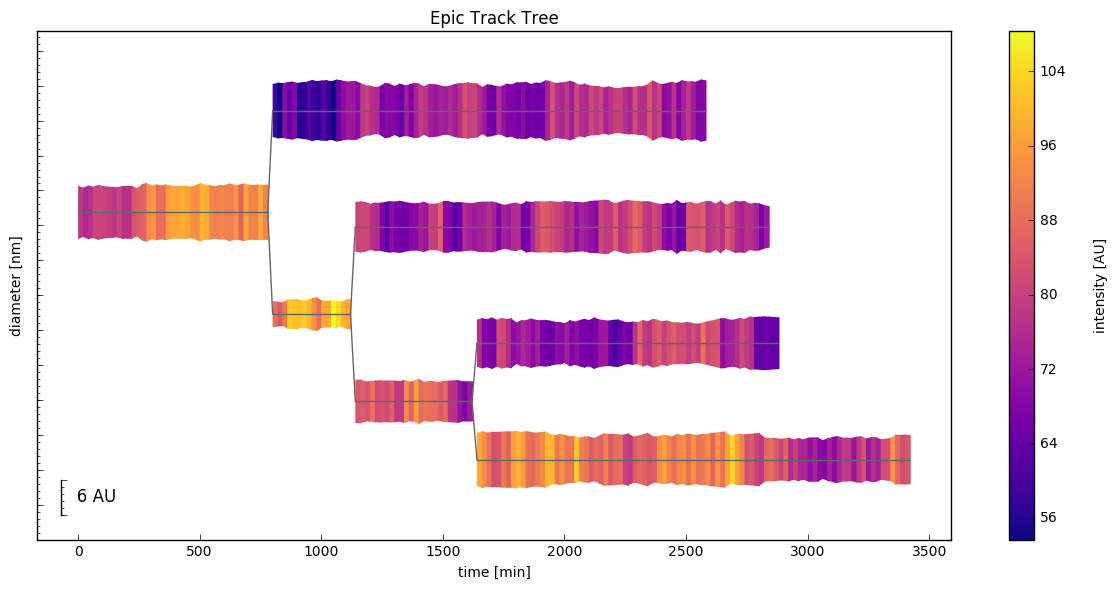

In [13]:
### PLOT 1: Sized by measure 1, colored by measure 2

# Initialize figure and set size
fig = plt.figure(figsize=plot1_size)
ax  = plt.gca()

# Prepare colormap
cmap = plt.cm.get_cmap(plot1_cmap)
vmin = min([np.min(tree[ID][plot1_color_track]) for ID in tree.keys()])
vmax = max([np.max(tree[ID][plot1_color_track]) for ID in tree.keys()])

# Prepare scale
scale = plot1_scale

# For each track...
for ID in tree.keys():
    
    # Get the track's position, size, color
    p = np.array([tree[ID]['position'] for step in tree[ID]['indices']])  # Repeated for plotting
    s = tree[ID][plot1_size_track]
    c = tree[ID][plot1_color_track]
    
    # Create the size-based area with color-based coloring
    for step in range(1,len(s)):
        overstep = np.abs(tree[ID]['times'][step-1]-tree[ID]['times'][step])*0.2
        step_x   = [tree[ID]['times'][step-1], tree[ID]['times'][step]+overstep]
        step_ylo = [p[step-1]*scale-(s[step-1]/2), p[step]*scale-(s[step]/2)]
        step_yhi = [p[step-1]*scale+(s[step-1]/2), p[step]*scale+(s[step]/2)]
        plt.fill_between(step_x, step_yhi, step_ylo,
                         facecolor=cmap((c[step]-vmin)/(vmax-vmin)), 
                         edgecolor='')

    # Create the position-based main line
    plt.plot(tree[ID]['times'], p*scale, '0.4', lw=1)
    
    # Create lines connecting branching events
    if tree[ID]['branches'][0] != '_leaf_':
        
        # x positions: (time point before event, time point after event)
        x  = np.array((tree[ID]['times'][-1], 
                       tree[ID]['times'][-1] + 1*time_resolution ))
        
        # y positions: (position before event, position after event)
        y1 = np.array((tree[ID]['position'], tree[tree[ID]['branches'][0]]['position']))
        y2 = np.array((tree[ID]['position'], tree[tree[ID]['branches'][1]]['position']))
        
        # Plot the lines
        plt.plot(x, y1*scale, '0.4', lw=1)
        plt.plot(x, y2*scale, '0.4', lw=1)

# Colorbar 
scat = plt.scatter([10,10], [10,10], c=[0,1],  # Invisible fake plot for colorbar
                   cmap=plot1_cmap, vmin=vmin, vmax=vmax,
                   alpha=0)
cbar = plt.colorbar(scat) 
cbar.set_alpha(1)
cbar.draw_all()
cbar.ax.get_yaxis().labelpad = 20
cbar.set_label(plot1_color_label, rotation=90)

# Labels
plt.xlabel(plot1_xlabel)
plt.ylabel(plot1_ylabel)
plt.title(plot1_title)

# X axis cosmetics
xmaxtime = max([np.max(tree[ID]['times']) for ID in tree.keys()])
xmintime = min([np.min(tree[ID]['times']) for ID in tree.keys()])
xoffset  = (xmaxtime-xmintime)*0.05
plt.xlim([xmintime-xoffset, xmaxtime+xoffset])

# Y axis cosmetics
ymaxpos    = max([tree[ID]['position'] for ID in tree.keys()]) * scale
yminpos    = min([tree[ID]['position'] for ID in tree.keys()]) * scale
max_m      = max([np.max(tree[ID][plot1_size_track]) for ID in tree.keys()])
yoffset    = (ymaxpos-yminpos)*0.05 + max_m
ytickspace = (ymaxpos-yminpos)/10.0
ax.set_ylim([yminpos-yoffset, ymaxpos+yoffset])
majorspace = np.arange(yminpos-yoffset, ymaxpos+yoffset, ytickspace)
minorspace = np.arange(yminpos-yoffset ,ymaxpos+yoffset, ytickspace/5.0)
ax.yaxis.set_ticks(majorspace)
ax.yaxis.set_ticks(minorspace, minor=True)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.tick_params(labelleft='off')

# Inset scale bar
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
ax_inset = zoomed_inset_axes(ax, 1, loc=3, borderpad=1.5)
ax_inset.plot([],[])
ax_inset.set_ylim([majorspace[0],majorspace[1]])
ax_inset.spines['top'].set_visible(False)
ax_inset.spines['right'].set_visible(False)
ax_inset.spines['bottom'].set_visible(False)
ax_inset.get_xaxis().set_visible(False)
ax_inset.get_yaxis().tick_left() 
ax_inset.patch.set_visible(False)
ax_inset.tick_params(labelleft='off')
ax_inset.yaxis.set_ticks(minorspace, minor=True)
ax_inset.yaxis.set_ticks(majorspace)
ax_inset.set_ylim([majorspace[0],majorspace[1]])
ax_inset.yaxis.set_label_coords(0, 0.5)
ylbl = ax_inset.set_ylabel("   "+plot1_scbar_label % ytickspace, 
                           fontsize=12, va='center', ha='left')
ylbl.set_rotation(0)

# Tight layout
# Note: It complains a bit because of the inset, hence the catch.
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.tight_layout()
    
# Done
plt.show()

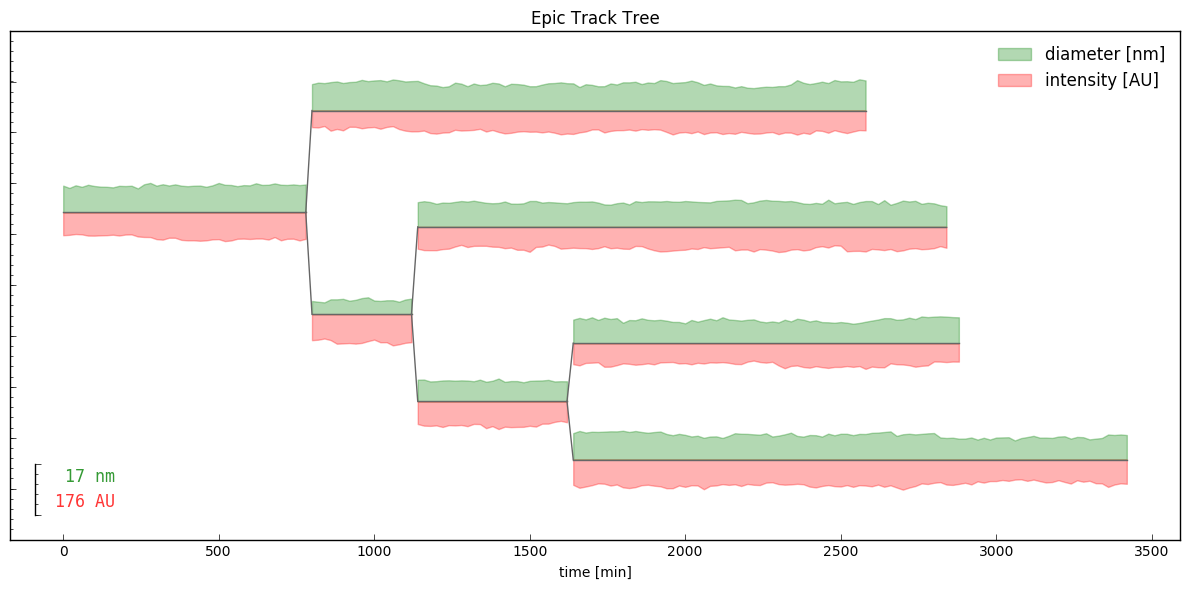

In [14]:
### PLOT 2: Sized by both measures

# Initialize figure and set size
fig = plt.figure(figsize=plot2_size)
ax  = plt.gca()

# Prepare scale
scale = plot2_scale * 2.0

# For scaling measure2 to measure_1
max_m1 = max([np.max(tree[ID][plot2_size1_track]) for ID in tree.keys()])
max_m2 = max([np.max(tree[ID][plot2_size2_track]) for ID in tree.keys()])

# For each track...
for ID in tree.keys():

    # Get the track's position and the two measures, the second normalized to the first
    p  = np.array([tree[ID]['position'] for step in tree[ID]['indices']])  # Repeated for plotting
    s1 = tree[ID][plot2_size1_track]
    s2 = tree[ID][plot2_size2_track] / max_m2 * max_m1
    
    # Create the size-based area on top
    plt.fill_between(tree[ID]['times'], p*scale+s1, p*scale,
                     edgecolor='g', facecolor='g', alpha=0.3, label=plot2_label1)  
    plot2_label1 = '_nolegend_' # Legend handling
    
    # Create the lyso-tracker-based area on the bottom
    plt.fill_between(tree[ID]['times'], p*scale, p*scale-s2,
                     edgecolor='r', facecolor='r', alpha=0.3, label=plot2_label2)
    plot2_label2 = '_nolegend_'  # Legend handling
    
    # Create the position-based main line
    plt.plot(tree[ID]['times'], p*scale, c='0.4', lw=1)

    # Create lines connecting branching events
    if tree[ID]['branches'][0] != '_leaf_':
        
        # x positions: (time point before event, time point after event)
        x  = np.array((tree[ID]['times'][-1], 
                       tree[ID]['times'][-1] + 1*time_resolution ))
        
        # y positions: (position before event, position after event)
        y1 = np.array((tree[ID]['position'], tree[tree[ID]['branches'][0]]['position']))
        y2 = np.array((tree[ID]['position'], tree[tree[ID]['branches'][1]]['position']))
        
        # Plot the lines
        plt.plot(x, y1*scale, '0.4', lw=1)
        plt.plot(x, y2*scale, '0.4', lw=1)
    
# Legend
plt.legend(fontsize=12, frameon=False)

# Labels
plt.xlabel(plot2_xlabel)
plt.title(plot2_title)

# X axis cosmetics
xmaxtime = max([np.max(tree[ID]['times']) for ID in tree.keys()])
xmintime = min([np.min(tree[ID]['times']) for ID in tree.keys()])
xoffset  = (xmaxtime-xmintime)*0.05
plt.xlim([xmintime-xoffset, xmaxtime+xoffset])

# Y axis cosmetics
ymaxpos    = max([tree[ID]['position'] for ID in tree.keys()]) * scale
yminpos    = min([tree[ID]['position'] for ID in tree.keys()]) * scale
yoffset    = (ymaxpos-yminpos)*0.05 + 2.0*max_m1
ytickspace = (ymaxpos-yminpos+2.0*yoffset) / 10.0
ax.set_ylim([yminpos-yoffset, ymaxpos+yoffset])
majorspace = np.arange(yminpos-yoffset, ymaxpos+yoffset, ytickspace)
minorspace = np.arange(yminpos-yoffset ,ymaxpos+yoffset, ytickspace/5.0)
ax.yaxis.set_ticks(majorspace)
ax.yaxis.set_ticks(minorspace, minor=True)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.tick_params(labelleft='off')

# Inset scale bar
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
ax_inset = zoomed_inset_axes(ax, 1, loc=3, borderpad=1.5)
ax_inset.plot([],[])
ax_inset.set_ylim([majorspace[0],majorspace[1]])
ax_inset.spines['top'].set_visible(False)
ax_inset.spines['right'].set_visible(False)
ax_inset.spines['bottom'].set_visible(False)
ax_inset.get_xaxis().set_visible(False)
ax_inset.get_yaxis().tick_left() 
ax_inset.patch.set_visible(False)
ax_inset.tick_params(labelleft='off')
ax_inset.yaxis.set_ticks(minorspace, minor=True)
ax_inset.yaxis.set_ticks(majorspace)
ax_inset.set_ylim([majorspace[0],majorspace[1]])
ax_inset.text(0.0, 0.75, "  "+plot2_scbar_label1 % ytickspace, 
              fontsize=12, va='center', ha='left', 
              color='g', alpha=0.8, fontdict={'family' : 'monospace'},
              transform=ax_inset.transAxes)
ax_inset.text(0.0, 0.25, "  "+plot2_scbar_label2 % (ytickspace / max_m1 * max_m2), 
              fontsize=12, va='center', ha='left', 
              color='r', alpha=0.8, fontdict={'family' : 'monospace'},
              transform=ax_inset.transAxes)

# Tight layout
# Note: It complains a bit because of the inset, hence the catch.
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.tight_layout()
    
# Done
plt.show()

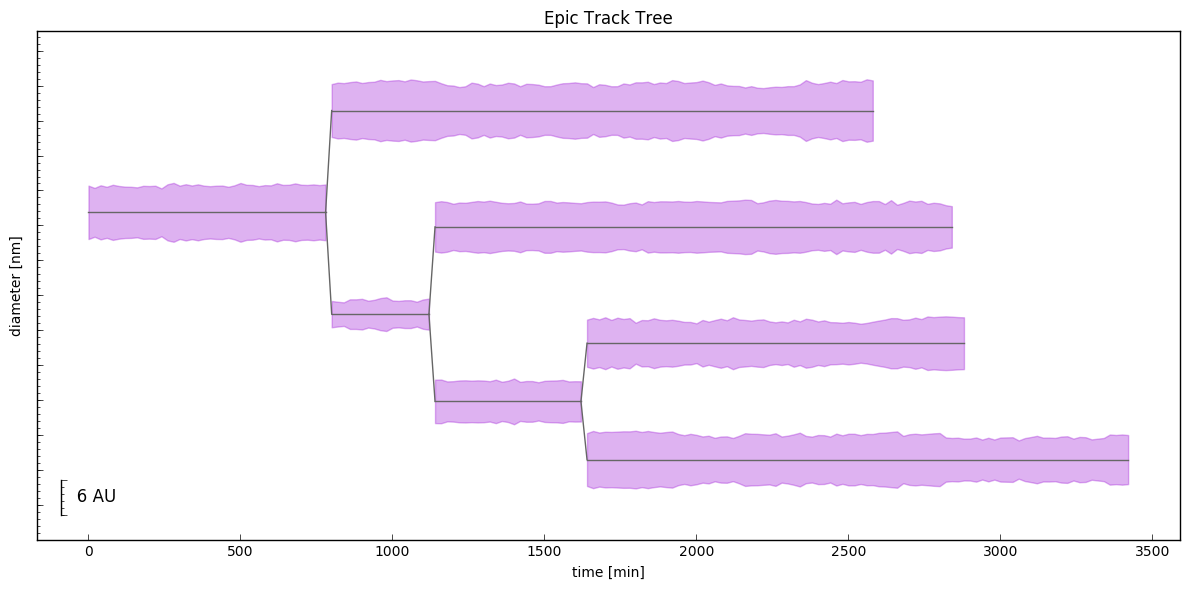

In [15]:
### PLOT 3: Sized by measure 1

# Initialize figure and set size
fig = plt.figure(figsize=plot3_size)
ax  = plt.gca()

# Prepare scale
scale = plot3_scale

# For each track...
for ID in tree.keys():
    
    # Get the track's position, size, color
    p = np.array([tree[ID]['position'] for step in tree[ID]['indices']])  # Repeated for plotting
    s = tree[ID][plot3_size_track]
    c = plot3_color

    # Create the size-based area on top
    plt.fill_between(tree[ID]['times'], p*scale+(s/2), p*scale-(s/2),
                     edgecolor=c, facecolor=c, alpha=0.3)

    # Create the position-based main line
    plt.plot(tree[ID]['times'], p*scale, '0.4', lw=1)
    
    # Create lines connecting branching events
    if tree[ID]['branches'][0] != '_leaf_':
        
        # x positions: (time point before event, time point after event)
        x  = np.array((tree[ID]['times'][-1], 
                       tree[ID]['times'][-1] + 1*time_resolution ))
        
        # y positions: (position before event, position after event)
        y1 = np.array((tree[ID]['position'], tree[tree[ID]['branches'][0]]['position']))
        y2 = np.array((tree[ID]['position'], tree[tree[ID]['branches'][1]]['position']))
        
        # Plot the lines
        plt.plot(x, y1*scale, '0.4', lw=1)
        plt.plot(x, y2*scale, '0.4', lw=1)

# Labels
plt.xlabel(plot3_xlabel)
plt.ylabel(plot3_ylabel)
plt.title(plot3_title)

# X axis cosmetics
xmaxtime = max([np.max(tree[ID]['times']) for ID in tree.keys()])
xmintime = min([np.min(tree[ID]['times']) for ID in tree.keys()])
xoffset  = (xmaxtime-xmintime)*0.05
plt.xlim([xmintime-xoffset, xmaxtime+xoffset])

# Y axis cosmetics
ymaxpos    = max([tree[ID]['position'] for ID in tree.keys()]) * scale
yminpos    = min([tree[ID]['position'] for ID in tree.keys()]) * scale
max_m      = max([np.max(tree[ID][plot3_size_track]) for ID in tree.keys()])
yoffset    = (ymaxpos-yminpos)*0.05 + max_m
ytickspace = (ymaxpos-yminpos)/10.0
ax.set_ylim([yminpos-yoffset, ymaxpos+yoffset])
majorspace = np.arange(yminpos-yoffset, ymaxpos+yoffset, ytickspace)
minorspace = np.arange(yminpos-yoffset ,ymaxpos+yoffset, ytickspace/5.0)
ax.yaxis.set_ticks(majorspace)
ax.yaxis.set_ticks(minorspace, minor=True)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.tick_params(labelleft='off')

# Inset scale bar
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
ax_inset = zoomed_inset_axes(ax, 1, loc=3, borderpad=1.5)
ax_inset.plot([],[])
ax_inset.set_ylim([majorspace[0],majorspace[1]])
ax_inset.spines['top'].set_visible(False)
ax_inset.spines['right'].set_visible(False)
ax_inset.spines['bottom'].set_visible(False)
ax_inset.get_xaxis().set_visible(False)
ax_inset.get_yaxis().tick_left() 
ax_inset.patch.set_visible(False)
ax_inset.tick_params(labelleft='off')
ax_inset.yaxis.set_ticks(minorspace, minor=True)
ax_inset.yaxis.set_ticks(majorspace)
ax_inset.set_ylim([majorspace[0],majorspace[1]])
ax_inset.yaxis.set_label_coords(0, 0.5)
ylbl = ax_inset.set_ylabel("   "+plot3_scbar_label % ytickspace, 
                           fontsize=12, va='center', ha='left')
ylbl.set_rotation(0)

# Tight layout
# Note: It complains a bit because of the inset, hence the catch.
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.tight_layout()
    
# Done
plt.show()

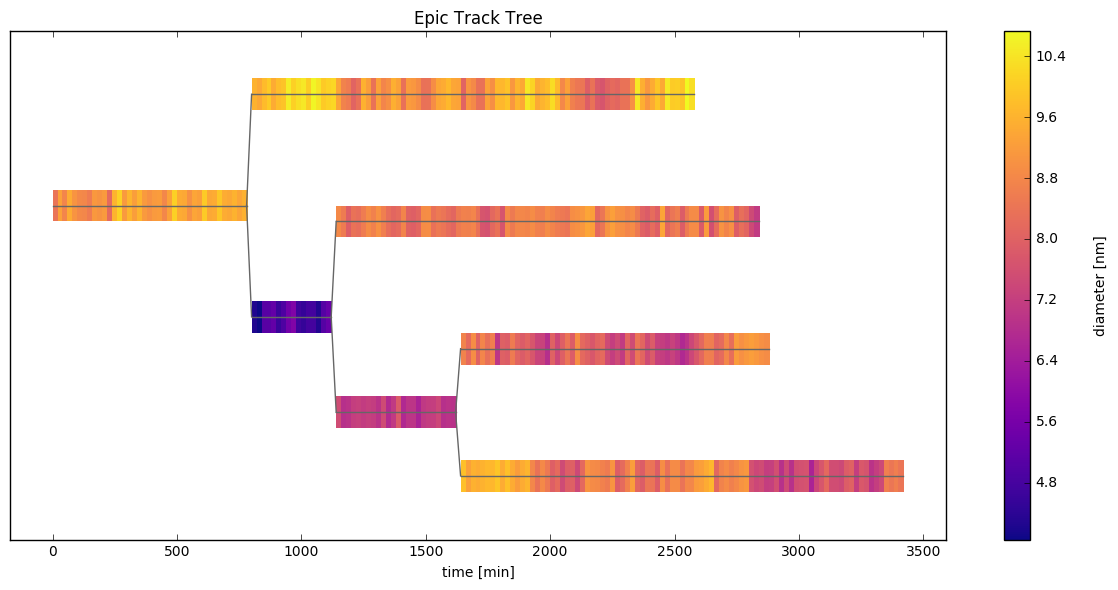

In [16]:
### PLOT 4: Colored by measure 1

# Initialize figure and set size
fig = plt.figure(figsize=plot4_size)
ax  = plt.gca()

# Prepare colormap
cmap = plt.cm.get_cmap(plot4_cmap)
vmin = min([np.min(tree[ID][plot4_color_track]) for ID in tree.keys()])
vmax = max([np.max(tree[ID][plot4_color_track]) for ID in tree.keys()])

# Prepare scale
scale = plot4_scale

# For each track...
for ID in tree.keys():
    
    # Get the track's position, size, color
    p = np.array([tree[ID]['position'] for step in tree[ID]['indices']])  # Repeated for plotting
    s = [plot4_scale/2.0 for i in tree[ID][plot4_color_track]]
    c = tree[ID][plot4_color_track]
    
    # Create the size-based area with color-based coloring
    for step in range(1,len(s)):
        overstep = np.abs(tree[ID]['times'][step-1]-tree[ID]['times'][step])*0.2
        step_x   = [tree[ID]['times'][step-1], tree[ID]['times'][step]+overstep]
        step_ylo = [p[step-1]*scale-(s[step-1]/2), p[step]*scale-(s[step]/2)]
        step_yhi = [p[step-1]*scale+(s[step-1]/2), p[step]*scale+(s[step]/2)]
        plt.fill_between(step_x, step_yhi, step_ylo,
                         facecolor=cmap((c[step]-vmin)/(vmax-vmin)), 
                         edgecolor='')

    # Create the position-based main line
    plt.plot(tree[ID]['times'], p*scale, '0.4', lw=1)
    
    # Create lines connecting branching events
    if tree[ID]['branches'][0] != '_leaf_':
        
        # x positions: (time point before event, time point after event)
        x  = np.array((tree[ID]['times'][-1], 
                       tree[ID]['times'][-1] + 1*time_resolution ))
        
        # y positions: (position before event, position after event)
        y1 = np.array((tree[ID]['position'], tree[tree[ID]['branches'][0]]['position']))
        y2 = np.array((tree[ID]['position'], tree[tree[ID]['branches'][1]]['position']))
        
        # Plot the lines
        plt.plot(x, y1*scale, '0.4', lw=1)
        plt.plot(x, y2*scale, '0.4', lw=1)

# Colorbar 
scat = plt.scatter([10,10], [10,10], c=[0,1],  # Invisible fake plot for colorbar
                   cmap=plot4_cmap, vmin=vmin, vmax=vmax,
                   alpha=0)
cbar = plt.colorbar(scat) 
cbar.set_alpha(1)
cbar.draw_all()
cbar.ax.get_yaxis().labelpad = 20
cbar.set_label(plot4_color_label, rotation=90)

# Labels
plt.xlabel(plot4_xlabel)
plt.title(plot4_title)

# X axis cosmetics
xmaxtime = max([np.max(tree[ID]['times']) for ID in tree.keys()])
xmintime = min([np.min(tree[ID]['times']) for ID in tree.keys()])
xoffset  = (xmaxtime-xmintime)*0.05
plt.xlim([xmintime-xoffset, xmaxtime+xoffset])

# Y axis cosmetics
ax.yaxis.set_visible(False)

# Tight layout
# Note: It complains a bit because of the inset, hence the catch.
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.tight_layout()
    
# Done
plt.show()